## Clasificación de los dígitos de Mnist en forma de set de puntos

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import chamfer_loss
from fspool import FSPool
from model import FSEncoder
from model import FSEncoderClasification
from MnistSet import MNISTSet
from MnistSet import get_loader

### Preparamos los datos de entreno y test

In [2]:
batch_size = 32

In [3]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)

0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Procesando el dataset...


/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217280611/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Listo!


In [4]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

Procesando el dataset...
Listo!


In [6]:
from time import sleep
from tqdm import tqdm

In [10]:
set_channels = 2
set_size = 342
  
hidden_dim = 32
iters = 10
latent_dim = 16
lr = 0.001
n_epochs = 100
net = FSEncoderClasification(set_channels,latent_dim,hidden_dim)

In [11]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [11]:
 net = net.cuda()

In [12]:
net.train()
for epoch in range(n_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input, target_set, target_mask = map(lambda x: x.cuda(), sample)
            optimizer.zero_grad()
            output = net(target_set,target_mask)
            loss = F.cross_entropy(output, input)
            acc = (output.max(dim=1)[1] == input).float().mean()
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

  0%|          | 0/1875 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 99: 100%|██████████| 1875/1875 [00:35<00:00, 52.35batch/s, acc=93.8, loss=0.0801]


In [13]:
net.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {epoch}")
        input, target_set, target_mask = map(lambda x: x.cuda(), sample)
        output = net(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

  0%|          | 0/312 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 99: 100%|██████████| 312/312 [00:04<00:00, 63.70batch/s, acc=93.8, loss=0.275]


In [18]:
#torch.save(net.state_dict(),'model.pth')

In [13]:
model = torch.load('model.pth' ,map_location=torch.device('cpu'))
miNet = FSEncoderClasification(set_channels,latent_dim,hidden_dim)

In [15]:
miNet.load_state_dict(torch.load('model.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [18]:
miNet = miNet
miNet.eval()
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {0}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = miNet(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())

Epoch 0: 100%|███████| 312/312 [00:10<00:00, 28.52batch/s, acc=93.8, loss=0.129]


In [30]:
miNet

FSEncoderClasification(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (pool): FSPool()
)

## Visualización de los filtros

In [103]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as np

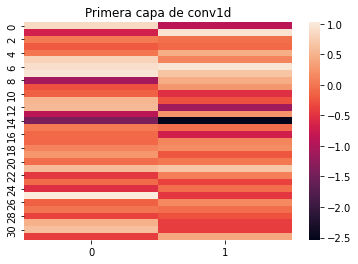

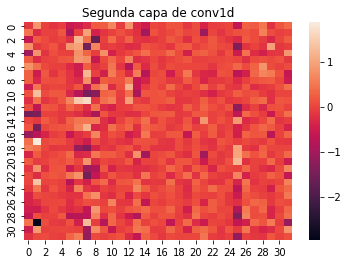

In [50]:
filters= miNet.conv[0].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Primera capa de conv1d")
pyplot.show()
filters= miNet.conv[2].weight
data = filters.squeeze(2).detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Segunda capa de conv1d")
pyplot.show()

torch.Size([32, 21])


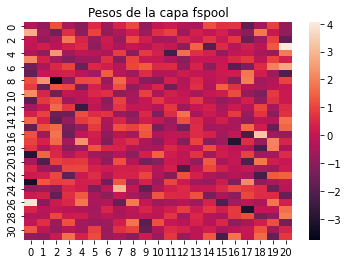

In [56]:
filters= miNet.pool.weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Pesos de la capa fspool")
pyplot.show()

torch.Size([32, 32])


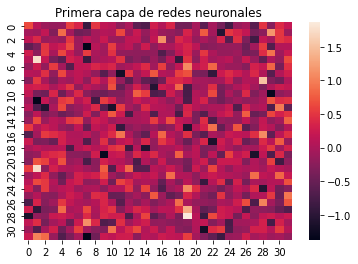

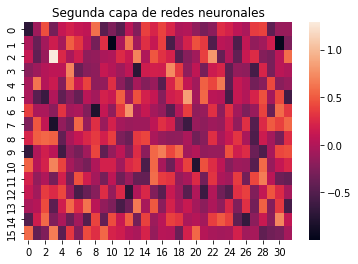

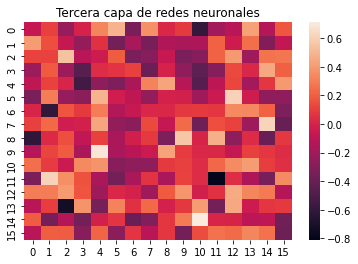

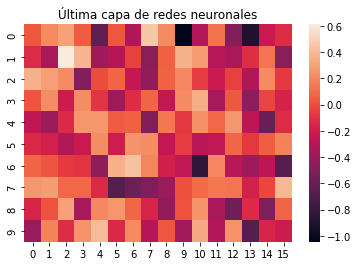

In [58]:
filters= miNet.lin[0].weight
print(filters.shape)
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Primera capa de redes neuronales")
pyplot.show()
filters= miNet.lin[2].weight
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Segunda capa de redes neuronales")
pyplot.show()
filters= miNet.classifier[0].weight
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Tercera capa de redes neuronales")
pyplot.show()
filters= miNet.classifier[2].weight
data = filters.detach().numpy()
sn.heatmap(data, annot=False, fmt='g')
pyplot.title("Última capa de redes neuronales")
pyplot.show()

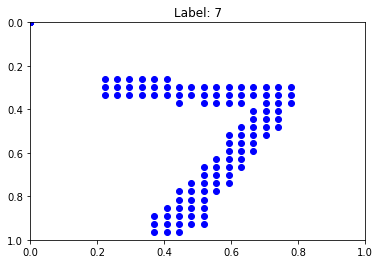

torch.Tensor

In [116]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[0]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()
sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)


In [160]:
with torch.no_grad():
    pred = miNet(sample,mask_sample)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),expected.item()))

We obtained 7, and the expected is: 7


In [206]:
#Creación del modelo pre-fspooling
class Model1(nn.Module):
    def __init__(self, input_channels, output_channels, dim):
        super().__init__()
        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        #self.conv[0] = miNet.conv[0].weight
        #self.conv[2] = miNet.conv[2].weight
        #self.lin = self.lin.fill_(miNet.lin.weight)
        #self.classifier = self.classifier.fill_(miNet.classifier.weight)
        #self.pool = FSPool(dim, 20, relaxed=False)

    def forward(self, x, mask=None):
        x = self.conv(x)
        #x, perm = self.pool(x)
        #x = self.lin(x)
        #x = self.classifier(x)
        return x
#Creación del modelo post-fspooling

In [221]:
#Creación del modelo pre-fspooling
class Model2(nn.Module):
    def __init__(self, input_channels, output_channels, dim):
        super().__init__()
        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        #self.conv[0] = miNet.conv[0].weight
        #self.conv[2] = miNet.conv[2].weight
        #self.lin = self.lin.fill_(miNet.lin.weight)
        #self.classifier = self.classifier.fill_(miNet.classifier.weight)
        self.pool = FSPool(dim, 20, relaxed=False)

    def forward(self, x, mask=None):
        x = self.conv(x)
        x, perm = self.pool(x)
        #x = self.lin(x)
        #x = self.classifier(x)
        return x
#Creación del modelo post-fspooling

In [280]:
#Creación del modelo pre-fspooling
class Model3(nn.Module):
    def __init__(self, input_channels, output_channels, dim):
        super().__init__()
        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
        self.conv = nn.Sequential(
            nn.Conv1d(input_channels, dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, 1),
        )
        #self.conv[0] = miNet.conv[0].weight
        #self.conv[2] = miNet.conv[2].weight
        self.lin = nn.Sequential(
            nn.Linear(dim, dim, 1),
            nn.ReLU(inplace=True),
            nn.Linear(dim, output_channels, 1),
        )
        #self.classifier = self.classifier.fill_(miNet.classifier.weight)
        self.pool = FSPool(dim, 20, relaxed=False)

    def forward(self, x, mask=None):
        x = self.conv(x)
        x, perm = self.pool(x)
        x = self.lin(x)
        #x = self.classifier(x)
        return x
#Creación del modelo post-fspooling

In [212]:
pre_fspool = miNet.conv
pre_fspool

Sequential(
  (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
  (1): ReLU(inplace=True)
  (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
)

In [228]:
post_fspool = miNet.pool
post_fspool

FSPool()

torch.Size([1, 32, 342])


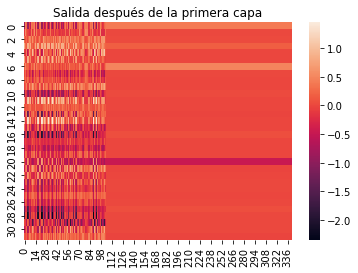

torch.Size([1, 32])


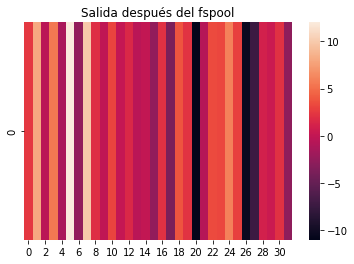

tensor([[  2.4619,   8.1123,  -0.4719,   5.4784,  -1.3521,  12.0079,  -2.5932,
           9.9363,   1.9062,  -0.2056,   3.0833,   0.0487,   1.4858,  -0.4921,
           0.0397,  -2.6345,   2.0616,  -3.7978,   3.7567,   2.1446, -11.0183,
          -0.7330,   3.3015,   3.1608,   5.9236,   2.8803, -10.4164,  -7.3988,
           1.0146,   0.4287,   2.0999,  -2.7661]])


In [284]:
model1 = Model1(set_channels,latent_dim,hidden_dim)
model2 = Model2(set_channels,latent_dim,hidden_dim)
model1.conv = pre_fspool
model2.conv = pre_fspool
model2.pool = post_fspool
#print(miNet.conv[0].weight) 
#print(model1.conv[0].weight)
with torch.no_grad():
    pred = model1(sample,mask_sample)
    print(pred.shape)
    nfeatures_pred = pred
    data = pred.squeeze(0).detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después de la primera capa")
    pyplot.show()
    
    pred = model2(sample,mask_sample)
    print(pred.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    pyplot.title("Salida después del fspool")
    pyplot.show()
    print(pred)
    nfeatures = pred
    
    

## Visualización de los puntos críticos

In [293]:
npoints = sample.squeeze(0).squeeze(0).numpy()
nfeatures.shape
nfeatures_prev = nfeatures_pred.squeeze(0)
print(nfeatures_prev.shape)
critical = np.zeros(342)
nfeature = nfeatures.squeeze(0).numpy()
print(nfeature)
for f in range(32):
    for p in range(342):
        if nfeatures_prev[f,p] == nfeature[f]:
            critical[p] = critical[p] +1
print(critical)
print("+++++++++++++++++")
print(nfeatures_prev.shape)

torch.Size([32, 342])
[  2.4619327    8.112284    -0.47186106   5.478394    -1.3520725
  12.007883    -2.5931895    9.936328     1.90622     -0.20556091
   3.0833201    0.04869604   1.4857514   -0.49212384   0.03970689
  -2.634492     2.0615869   -3.7978432    3.7567182    2.1446004
 -11.018257    -0.7330489    3.3014803    3.1608384    5.9236
   2.88028    -10.416417    -7.3988466    1.014563     0.4287213
   2.09993     -2.7660809 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0